### Basic Data Analysis

The data is obtained from https://www.kaggle.com/marklvl/activity-recognition-with-healthy-older-people. We combined the several data files into a single file.
The data features contained include :
Accelerometer readings in G (frontal, vertical, Lateral)
The gender of the person being monitored is also included,  together with the sensor ID ,  signal strength, sampling frequency, and finally the activity class that the person is engaged.


1 - Sitting on a bed

2 - Sitting on a chair

3 - Lying down

4 - Ambulating (moving around in the room)

Load the data from the url and perform basic data analysis.


In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:

url = 'https://raw.githubusercontent.com/hoyewhwa/data/master/combine_raw.csv'
df = pd.read_csv(url)
print(df.head())
print('>>> Check the sample size:')
print(df.shape)
print('>>> Check for the features: ')
print(df.describe())
print('>>> Check for missing values')
print(df.info())

   Time  FrontalAxis  VerticalAxis  ...   Phase  Frequence  Activity
0  0.00      0.27203       1.00820  ...  2.4252     924.25         1
1  0.50      0.27203       1.00820  ...  4.7369     921.75         1
2  1.50      0.44791       0.91636  ...  3.0311     923.75         1
3  1.75      0.44791       0.91636  ...  2.0371     921.25         1
4  2.50      0.34238       0.96229  ...  5.8920     920.25         1

[5 rows x 10 columns]
>>> Check the sample size:
(75128, 10)
>>> Check for the features: 
               Time   FrontalAxis  ...     Frequence      Activity
count  75128.000000  75128.000000  ...  75128.000000  75128.000000
mean     299.080416      0.714211  ...    922.670536      2.528378
std      257.503002      0.404585  ...      1.679093      0.864258
min        0.000000     -0.748080  ...    920.250000      1.000000
25%      121.250000      0.342380  ...    921.250000      2.000000
50%      250.715000      0.682420  ...    922.750000      3.000000
75%      402.500000      1

In [0]:
df.Activity.value_counts().sort_index()

1    16406
2     4911
3    51520
4     2291
Name: Activity, dtype: int64

In [0]:
df.Activity.value_counts(normalize=True).sort_index()

1    0.218374
2    0.065368
3    0.685763
4    0.030495
Name: Activity, dtype: float64

### Exploratory Data Analysis


   Histograms to show the distribution of the features.


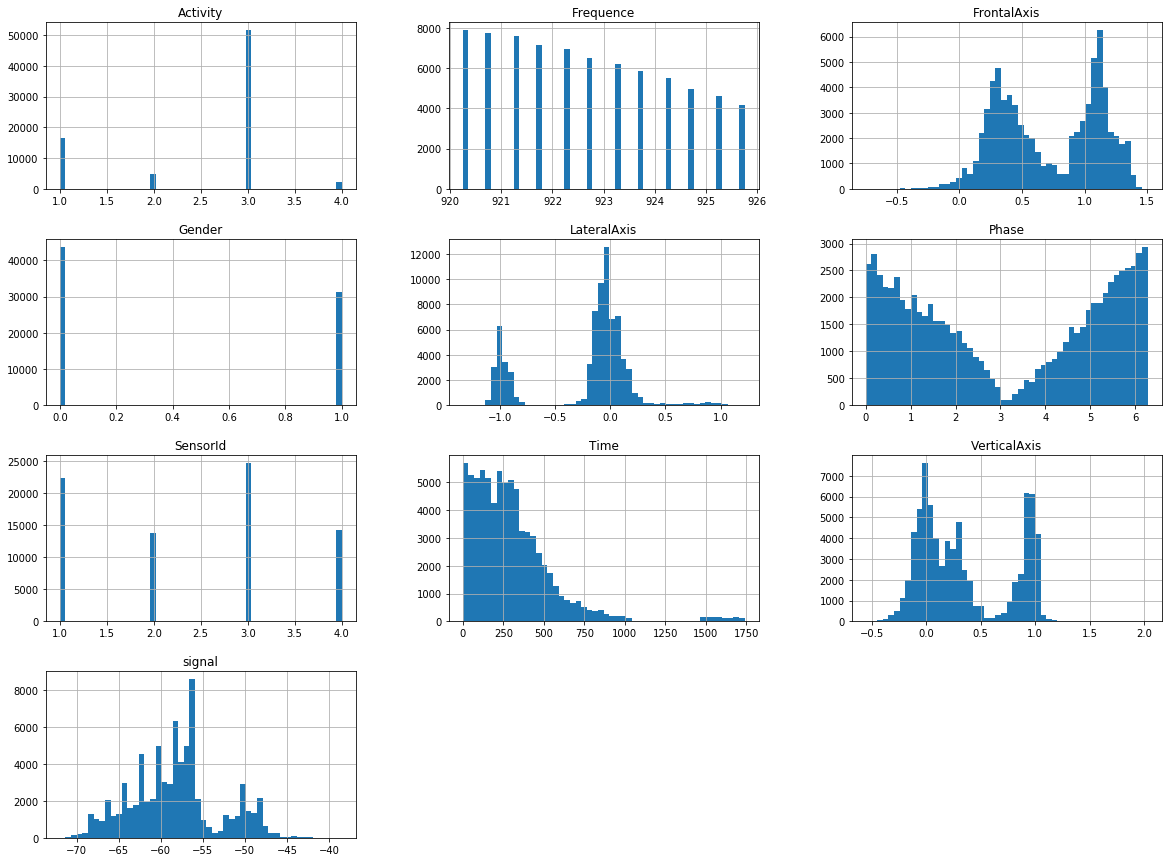

In [0]:
df.hist(bins=50, figsize=(20,15))
plt.show()

### Data Preparation

Drop all columns except FrontalAxis, VerticalAxis, LaterAxis and Activity.

In [0]:
df.drop(['Time', 'signal', 'Phase', 'Frequence', 'Gender', 'SensorId'], axis=1, inplace=True)

In [0]:
df.head()

,FrontalAxis,VerticalAxis,LateralAxis,Activity
0,0.27203,1.00820,-0.082102,1
1,0.27203,1.00820,-0.082102,1
2,0.44791,0.91636,-0.013684,1
3,0.44791,0.91636,-0.013684,1
4,0.34238,0.96229,-0.059296,1


Split the data into train and test set.

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.2, random_state=7)

X_train = train.values[:,0:3]
y_train = train.values[:,3]
X_test_set = test.values[:,0:3]
y_test = test.values[:,3]

Further split the train set into train and validation set.

In [0]:
X_train_set,  X_val_set, y_train_proper, y_val_proper = train_test_split(X_train, y_train, test_size=.2, random_state=42)

In [0]:
from sklearn.preprocessing import StandardScaler

feature_columns = df.columns[:-1]

scaler = StandardScaler()
X_train_proper = scaler.fit_transform(X_train_set)
X_val_proper = scaler.transform(X_val_set)
X_test = scaler.transform(X_test_set)

In [0]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

###Decision Tree classifier
Create a baseline Decision Tree classifier with default hyperparameters.

In [0]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train_proper, y_train_proper)

View the node_count and max_depth

In [0]:
dt.tree_.node_count, dt.tree_.max_depth

(3533, 29)

View the relative importance of the features.


In [0]:
dt.feature_importances_

array([0.13051427, 0.7607317 , 0.10875404])

[Text(0, 0.5, 'Relative Importance')]

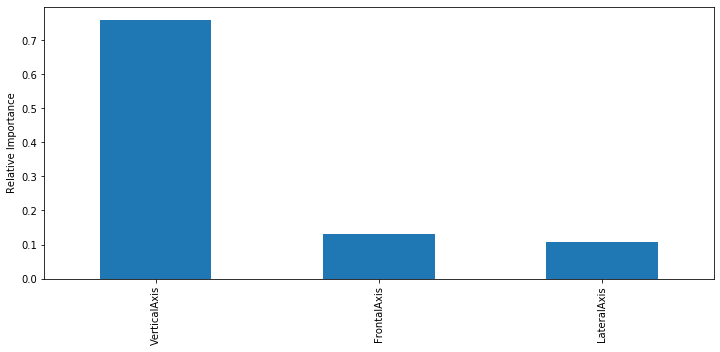

In [0]:
feature_imp = pd.Series(dt.feature_importances_, index=feature_columns).sort_values(ascending=False)
fig = plt.figure(figsize=(12,5))
ax = feature_imp.plot(kind='bar')
ax.set(ylabel='Relative Importance')

### Evaluation using Cross-Validation

In [0]:
from sklearn.model_selection import cross_val_score

cross_val_score(dt, X_train_proper, y_train_proper, cv=5, scoring='accuracy')

array([0.97775005, 0.97452693, 0.97410566, 0.97316693, 0.97628458])

In [0]:
from sklearn.model_selection import cross_val_predict

y_train_proper_pred = cross_val_predict(dt, X_train_proper, y_train_proper, cv=5)

In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print(precision_score(y_train_proper, y_train_proper_pred, average='weighted'))
print(recall_score(y_train_proper, y_train_proper_pred, average='weighted'))

0.9747064729511806
0.9751669058463842


### Decision Tree baseline model - Test with validation set

In [0]:
y_pred_val_dt = dt.predict(X_val_proper)

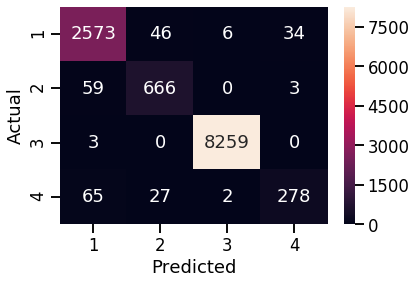

In [0]:
from sklearn.metrics import confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_val_proper, y_pred_val_dt)
ax = sns.heatmap(cm, annot=True, fmt='d')

labels = ['1', '2', '3', '4']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
ax.set_ylabel('Actual');
ax.set_xlabel('Predicted');

In [0]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

cr = classification_report(y_val_proper, y_pred_val_dt)
print(cr)


score_df = pd.DataFrame({'accuracy': accuracy_score(y_val_proper, y_pred_val_dt),
                         'precision': precision_score(y_val_proper, y_pred_val_dt, average='weighted'),
                         'recall': recall_score(y_val_proper, y_pred_val_dt, average='weighted'),
                         'f1': f1_score(y_val_proper, y_pred_val_dt, average='weighted')},
                         index=pd.Index([0]))
print(score_df)

              precision    recall  f1-score   support

         1.0       0.95      0.97      0.96      2659
         2.0       0.90      0.91      0.91       728
         3.0       1.00      1.00      1.00      8262
         4.0       0.88      0.75      0.81       372

    accuracy                           0.98     12021
   macro avg       0.93      0.91      0.92     12021
weighted avg       0.98      0.98      0.98     12021

   accuracy  precision    recall        f1
0  0.979619   0.979313  0.979619  0.979277


### Hyperparameters tuning using GridSearchCV

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': range(1, dt.tree_.max_depth+1, 2),
              'max_features': ['auto', 'sqrt', 'log2']}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Max depth has decreased to reduce overfitting.

In [0]:
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(4567, 27)

In [0]:
GR.best_params_

{'max_depth': 27, 'max_features': 'auto'}

### Evaluation using Cross-Validation

In [0]:
from sklearn.model_selection import cross_val_score

cross_val_score(GR, X_train_proper, y_train_proper, cv=5, scoring='accuracy')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr

array([0.9760865 , 0.97421501, 0.97597754, 0.97431097, 0.97420429])

In [0]:
from sklearn.model_selection import cross_val_predict

y_train_proper_pred = cross_val_predict(GR, X_train_proper, y_train_proper, cv=5)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr

In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print(precision_score(y_train_proper, y_train_proper_pred, average='weighted'))
print(recall_score(y_train_proper, y_train_proper_pred, average='weighted'))

0.9744797424413486
0.9749589234832886


### Decision Tree Classifier - Test with validation set.

In [0]:
y_pred_val_dt = GR.predict(X_val_proper)

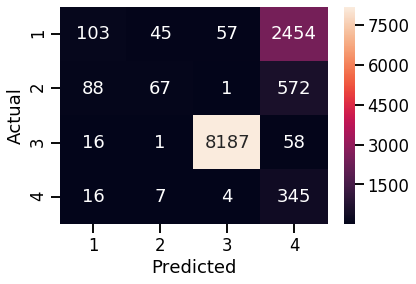

In [0]:
sns.set_context('talk')
cm = confusion_matrix(y_val_proper, y_pred_val_dt)
ax = sns.heatmap(cm, annot=True, fmt='d')

labels = ['1', '2', '3', '4']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
ax.set_ylabel('Actual');
ax.set_xlabel('Predicted');

In [0]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

cr = classification_report(y_val_proper, y_pred_val_dt)
print(cr)


score_df = pd.DataFrame({'accuracy': accuracy_score(y_val_proper, y_pred_val_dt),
                         'precision': precision_score(y_val_proper, y_pred_val_dt, average='weighted'),
                         'recall': recall_score(y_val_proper, y_pred_val_dt, average='weighted'),
                         'f1': f1_score(y_val_proper, y_pred_val_dt, average='weighted')},
                         index=pd.Index([0]))
print(score_df)

              precision    recall  f1-score   support

         1.0       0.46      0.04      0.07      2659
         2.0       0.56      0.09      0.16       728
         3.0       0.99      0.99      0.99      8262
         4.0       0.10      0.93      0.18       372

    accuracy                           0.72     12021
   macro avg       0.53      0.51      0.35     12021
weighted avg       0.82      0.72      0.71     12021

   accuracy  precision  recall        f1
0    0.7239   0.821225  0.7239  0.712592


### Decision Tree Classifier - Test with test set.

In [0]:
y_pred_dt = GR.predict(X_test)

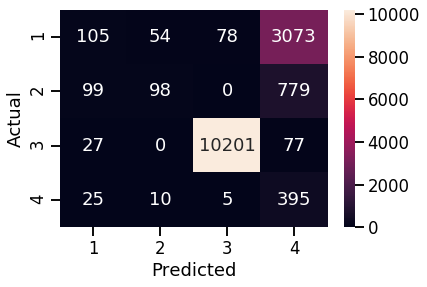

In [0]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred_dt)
ax = sns.heatmap(cm, annot=True, fmt='d')

labels = ['1', '2', '3', '4']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
ax.set_ylabel('Actual');
ax.set_xlabel('Predicted');

In [0]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

cr = classification_report(y_test, y_pred_dt)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred_dt),
                         'precision': precision_score(y_test, y_pred_dt, average='weighted'),
                         'recall': recall_score(y_test, y_pred_dt, average='weighted'),
                         'f1': f1_score(y_test, y_pred_dt, average='weighted')},
                         index=pd.Index([0]))



print(score_df)

              precision    recall  f1-score   support

         1.0       0.41      0.03      0.06      3310
         2.0       0.60      0.10      0.17       976
         3.0       0.99      0.99      0.99     10305
         4.0       0.09      0.91      0.17       435

    accuracy                           0.72     15026
   macro avg       0.52      0.51      0.35     15026
weighted avg       0.81      0.72      0.71     15026

   accuracy  precision    recall        f1
0  0.718688   0.812565  0.718688  0.708548


###Random Forest classifier
Create a baseline Random Forest classifier with default hyperparameters.

In [0]:
from sklearn.ensemble import RandomForestClassifier

RF_baseline = RandomForestClassifier(oob_score=False, 
                            bootstrap=True,
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)


RF_baseline.fit(X_train_proper, y_train_proper)



/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=True)

### Evaluation using Cross-Validation

In [0]:
cross_val_score(RF_baseline, X_train_proper, y_train_proper, cv=5, scoring='accuracy')

array([0.97639842, 0.97379913, 0.97472962, 0.97379095, 0.97732473])

In [0]:
y_train_proper_pred = cross_val_predict(RF_baseline, X_train_proper, y_train_proper, cv=5)

In [0]:
print(precision_score(y_train_proper, y_train_proper_pred, average='weighted'))
print(recall_score(y_train_proper, y_train_proper_pred, average='weighted'))

0.9747680549403726
0.9752085023190034


In [0]:
y_pred_val_rf = RF_baseline.predict(X_val_proper)

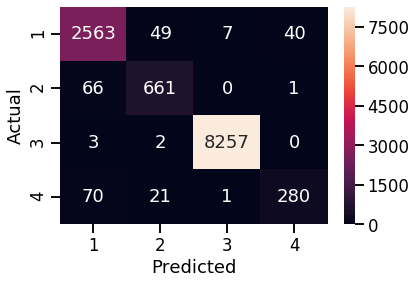

In [0]:
from sklearn.metrics import confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_val_proper, y_pred_val_rf)
ax = sns.heatmap(cm, annot=True, fmt='d')

labels = ['1', '2', '3', '4']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
ax.set_ylabel('Actual');
ax.set_xlabel('Predicted');

In [0]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

cr = classification_report(y_val_proper, y_pred_val_rf)
print(cr)


score_df = pd.DataFrame({'accuracy': accuracy_score(y_val_proper, y_pred_val_dt),
                         'precision': precision_score(y_val_proper, y_pred_val_dt, average='weighted'),
                         'recall': recall_score(y_val_proper, y_pred_val_dt, average='weighted'),
                         'f1': f1_score(y_val_proper, y_pred_val_dt, average='weighted')},
                         index=pd.Index([0]))
print(score_df)

              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96      2659
         2.0       0.90      0.91      0.90       728
         3.0       1.00      1.00      1.00      8262
         4.0       0.87      0.75      0.81       372

    accuracy                           0.98     12021
   macro avg       0.93      0.91      0.92     12021
weighted avg       0.98      0.98      0.98     12021

   accuracy  precision  recall        f1
0    0.7239   0.821225  0.7239  0.712592


### Evaluation of random forest classifier based on oob error

In [0]:
from sklearn.ensemble import RandomForestClassifier


RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()

# Iterate through a range of numbers of trees

for n_trees in [10, 50, 100, 500, 600, 800, 1000, 1100, 1200, 1300, 1400, 1500]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(X_train_proper, y_train_proper)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

,oob
n_trees,
10.0,0.033028
50.0,0.021589
100.0,0.021443
500.0,0.021089
600.0,0.020965
800.0,0.021069
1000.0,0.020923
1100.0,0.020902
1200.0,0.021027


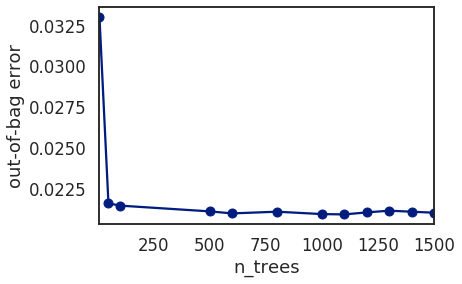

In [0]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

ax = rf_oob_df.plot(legend=False, marker='o')
ax.set(ylabel='out-of-bag error');

### Fit a whole new forest.

In [0]:
#rnd_clf = RF.set_params(n_estimators=1000, warm_start=False)
rnd_clf = RandomForestClassifier(n_estimators=1000, 
                                 oob_score=True, 
                                 random_state=42, 
                                 warm_start=False,
                                 n_jobs=-1)

rnd_clf.fit(X_train_proper, y_train_proper)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

### Evaluation using Cross-Validation

In [0]:
cross_val_score(rnd_clf, X_train_proper, y_train_proper, cv=5, scoring='accuracy')

array([0.97899771, 0.97525473, 0.97680948, 0.97628705, 0.97857291])

In [0]:
y_train_proper_pred = cross_val_predict(rnd_clf, X_train_proper, y_train_proper, cv=5)

In [0]:
print(precision_score(y_train_proper, y_train_proper_pred, average='weighted'))
print(recall_score(y_train_proper, y_train_proper_pred, average='weighted'))

0.9767841482535908
0.9771843347684116


### Random Forest Classifier - Test with validation set.

In [0]:
y_pred_val_rnd = rnd_clf.predict(X_val_proper)

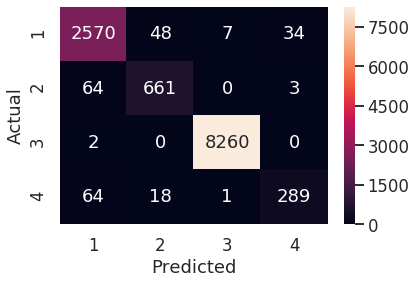

In [0]:
sns.set_context('talk')
cm = confusion_matrix(y_val_proper, y_pred_val_rnd)
ax = sns.heatmap(cm, annot=True, fmt='d')

labels = ['1', '2', '3', '4']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
ax.set_ylabel('Actual');
ax.set_xlabel('Predicted');


In [0]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

cr = classification_report(y_val_proper, y_pred_val_rnd)
print(cr)


score_df = pd.DataFrame({'accuracy': accuracy_score(y_val_proper, y_pred_val_rnd),
                         'precision': precision_score(y_val_proper, y_pred_val_rnd, average='weighted'),
                         'recall': recall_score(y_val_proper, y_pred_val_rnd, average='weighted'),
                         'f1': f1_score(y_val_proper, y_pred_val_rnd, average='weighted')},
                         index=pd.Index([0]))
print(score_df)

              precision    recall  f1-score   support

         1.0       0.95      0.97      0.96      2659
         2.0       0.91      0.91      0.91       728
         3.0       1.00      1.00      1.00      8262
         4.0       0.89      0.78      0.83       372

    accuracy                           0.98     12021
   macro avg       0.94      0.91      0.92     12021
weighted avg       0.98      0.98      0.98     12021

   accuracy  precision    recall        f1
0  0.979952   0.979675  0.979952  0.979689


### Test with test set.

In [0]:
y_pred_rnd = rnd_clf.predict(X_test)

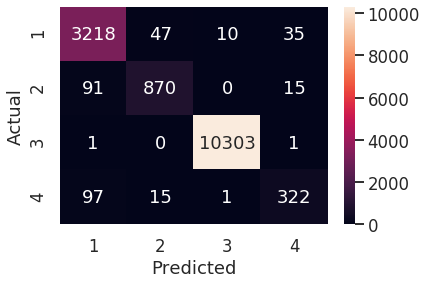

In [0]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred_rnd)
ax = sns.heatmap(cm, annot=True, fmt='d')

labels = ['1', '2', '3', '4']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
ax.set_ylabel('Actual');
ax.set_xlabel('Predicted');

In [0]:
cr = classification_report(y_test, y_pred_rnd)
print(cr)

score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred_rnd),
                         'precision': precision_score(y_test, y_pred_rnd, average='weighted'),
                         'recall': recall_score(y_test, y_pred_rnd, average='weighted'),
                         'f1': f1_score(y_test, y_pred_rnd, average='weighted')},
                         index=pd.Index([0]))



print(score_df)


              precision    recall  f1-score   support

         1.0       0.94      0.97      0.96      3310
         2.0       0.93      0.89      0.91       976
         3.0       1.00      1.00      1.00     10305
         4.0       0.86      0.74      0.80       435

    accuracy                           0.98     15026
   macro avg       0.94      0.90      0.92     15026
weighted avg       0.98      0.98      0.98     15026

   accuracy  precision    recall        f1
0  0.979169   0.978769  0.979169  0.978757
